# Task 5: Linear Models

_All credit for this jupyter notebook tutorial goes to the book "Hands-On Machine Learning with Scikit-Learn & TensorFlow" by Aurelien Geron. Modifications were made in preparation for the hands-on sessions._

# Setup

First, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Function to save a figure. This also decides that all output files 
# should stored in the subdirectorz 'classification'.
PROJECT_ROOT_DIR = "."
EXERCISE = "linmodels"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "output", EXERCISE, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Linear regression using the Normal Equation

Let's start with something simple: linear regression. As we learnt in the lecture, we can use the _normal equation_ to calculate the estimater theta_hat, an estimator for the parameter vector of the model. Let's start by generating some random data.

Saving figure generated_data_plot


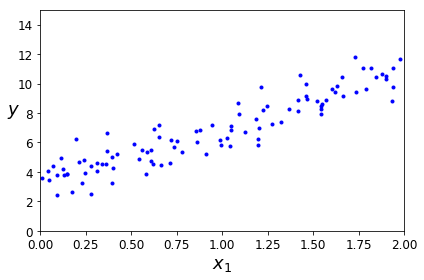

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 3 + 4 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Looks good. Without using any machine learning yet, we can just use numpy's `linalg.inv()` function which inverts matrices. As we saw in the lecture, the estimator for theta can be calculated as the product of (the transposed vector of X times X) times the transposed vector X times the vector of target values. We will also use the `dot()` function to multiply matrices. And one more step is necessary: we need to append an additional feature $x_0 = 1$ to the feature vector before we start:

In [3]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best)

[[3.21509616]
 [3.77011339]]


Ok, that's not perfect, but close enough. Where does the difference come from?

We can use this to make predictions of y values. Let's look at what the closed form would predict for data points at 0, 1 and 2:

In [4]:
X_new = np.array([[0], [1], [2]])
X_new_b = np.c_[np.ones((3, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
print(y_predict)

[[ 3.21509616]
 [ 6.98520954]
 [10.75532293]]


Are these accurate? Maybe it is more useful to plot the prediction as a line into the plot:

Saving figure linear_model_predictions


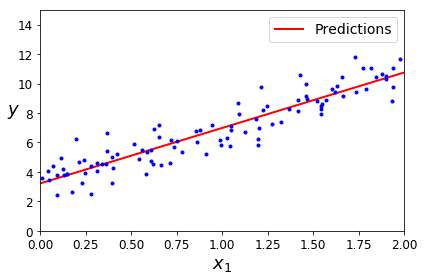

In [5]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper right", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions")
plt.show()

Linear regression can also be performed with Scikit-Learn and the `LinearRegression` class. We essentially only need to call its `fit()` function. This class uses a slightly more elaborate factorisation technique called _singular value decomposition_ to perform the invertion and matrix multiplication. This will scale better with high dimensionality of the matrix than calculating the inverse directly.

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

print("Predicted theta_0: %s" % lin_reg.intercept_[0])
print("Predicted theta_1: %s" % lin_reg.coef_[0][0])

Predicted theta_0: 3.2150961575467463
Predicted theta_1: 3.770113386438485


Let's try and see what our linear regression model predicts for the values at 0, 1 and 2:

In [7]:
lin_reg.predict(X_new)

array([[ 3.21509616],
       [ 6.98520954],
       [10.75532293]])

... which is almost the same as before.

# Linear regression using batch gradient descent

Let's try and implement linear regression with the batch gradient descent method! Quick reminder: gradient descent is an iterative approach to find the best estimate for our vector of model parameters theta. Using the learning rate eta, we iteratively adjust our estimates for theta in each learning step. The "direction" of adjustment is determined by the _gradient_ of the _mean square error_ of our theta values. Please have a look again at the slides of the lecture to find the definition. Can you remember why it's called _batch_ gradient descent?

Let's start with the following parameters and try to implement the iteration steps:

In [8]:
eta = 0.1              # learning rate of 0.1
n_iterations = 1000    # 1000 iterations by default
m = 100                # number of data points in the training set
theta = np.random.randn(2,1)   # let's start with random values

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

Let's try and make a prediction with the obtained values for theta:

In [9]:
X_new_b.dot(theta)

array([[ 3.21509616],
       [ 6.98520954],
       [10.75532293]])

If we implement the same missing code piece in the function below, we can make plots to compare a few different learning rates. Try it out!

Saving figure gradient_descent_plot


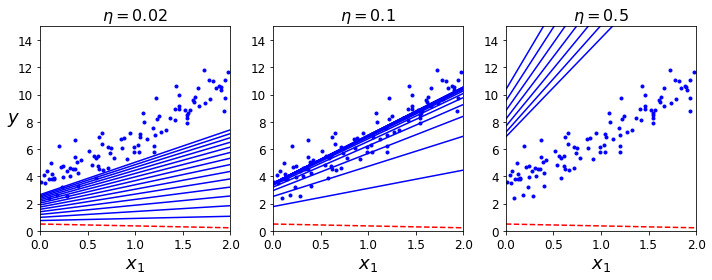

In [10]:
# This is to store the 'path' that our theta parameters walk for later.
# Ignore this for now, we will need it to compare to other methods.
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)            # Determine size of dataset
    plt.plot(X, y, "b.")    # Plot the data points
    n_iterations = 1000     # Fix the number of iterations
    
    # Now loop over all iterations
    for iteration in range(n_iterations):
        # For the first few, plot the prediction line to get a trend.
        if iteration < 15:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
            
        # Here we need to put the above piece of code again.
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        
        # Again, this is to store the 'path' of theta values for later.
        if theta_path is not None:
            theta_path.append(theta)

    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)


# Now let's plot some examples. First, start with random seeds for theta.
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()    

# Stochastic Gradient Descent

An alternative to the computationally very expensive BGD is the _stochastic gradient descent_ (SGD) method. As opposed to the previous method, the stochastic technique picks one instance from the dataset _randomly_ and adjusts our estimates for theta according to that instance. This means _a lot_ of jumping around, because we are following the randomness of the individual instances. On the other hand, we don't need to look at the entire dataset, so it's computationally a lot faster.

SGD has better chances to find the global minimum, because of its randomness, but it will _never_ converge to the optimal values per se. One common technique to overcome this problem is to adjust the learning rate according to a _schedule_ during the training process, i.e. start with a high learning rate and decrease it constantly to help to 'settle' in the global minimum.

But lets' get to the algorithm! First, reset the random seed. Also, for SGD we train in _epochs_, that is, once we've gone (randomly) through all instances of the training dataset _once_, we have finished one epoch of the training.

In [11]:
# Again, we will store the 'path' of theta for a comparison later.
theta_path_sgd = []

# Store the number of instances, this will correspond to the number
# of steps we go through in each epoch.
m = len(X_b)

# Reset the random seed to a fixed value.
np.random.seed(42)

Saving figure sgd_plot


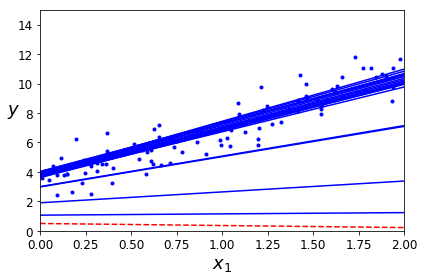

In [12]:
# Hyperparameters of the model. Let's start with these values,
# but feel free to adjust them! Maybe this will optimise the
# training in terms of training steps/convergence rate.
n_epochs = 50

# These are example parameters for the learning schedule. In this
# case we start with a learning rate of which value? Where are we
# after 1000 steps?
t0, t1 = 5, 50  
def learning_schedule(t):
    return t0 / (t + t1)

# Randomly initialise the theta values.
theta = np.random.randn(2,1)

# Loop of epochs and m steps in each epoch.
for epoch in range(n_epochs):
    for i in range(m):
        # This is just to plot the theta 'path' for the first couple
        # of steps. You can ignore this if statement.
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
            
        # Randomly pick an index between 0 and m.
        random_index = np.random.randint(m)
        
        # Can you implement this part of the code yourself? We will need:
        #  a) a way to use the random_index and pick an instance
        #  b) calculate the gradient based on that instance
        #  c) Calculate the correct learning rate from the schedule
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)        
        theta = theta - eta * gradients
        
        # Again, this is for the comparison of methods later.
        if epoch == 0 and i < 200:
            theta_path_sgd.append(theta)

# This is to plot the results.
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show()

Did this work? What are our predicted values for theta now? Is this a better prediction than with the BGD method?

In [13]:
print("Predicted theta_0: %s" % theta[0][0])
print("Predicted theta_1: %s" % theta[1][0])

Predicted theta_0: 2.762515503173958
Predicted theta_1: 3.5892926982530757


All of this, of course, is also implemented in Scikit-Learn. The learning schedule might be slightly different, but are the results comparable? Note: The `penalty=None` means that we do _not_ use regularisation, which we will only look at in the next tutorial.

In [14]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [15]:
print("Predicted theta_0: %s" % sgd_reg.intercept_[0])
print("Predicted theta_1: %s" % sgd_reg.coef_[0])

Predicted theta_0: 3.167822380592775
Predicted theta_1: 3.726029268138301


# Mini-batch gradient descent

Maybe 'taking the best of both worlds', the _mini-batch gradient descent_ is a compromise between the BGD and the SGD methods. Instead of taking all or just one instance, the gradient is evaluated on a _mini-batch_ of instances. This makes it a little more stable than SGD, especially with large mini-batches. And it allows for vectorisation optimisations in terms of computing. It has the same 'issue' as SGD, however, that it never stops at the optimal values for the estimators, but keeps walking around the global minimum. Therefore, a good learning schedule is pivotal to implement this technique successfully.

In [16]:
# Again, let's store the 'path' of theta values.
theta_path_mgd = []

# Let's only do 50 iterations for now and include 20 instances in
# each mini-batch. Maybe you can find more optimal values?
n_iterations = 50
minibatch_size = 20

# Reset random seed and pick random values for theta.
np.random.seed(42)
theta = np.random.randn(2,1)

# Again, these are only example values for the scheduling, there
# might be more optimal ones. What value do we start with? Which
# learning rate are we at at the end of the training?
t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0  # Count the number of steps.

# Loop over all iterations, and then (further below) over all
# instances in a mini-batch.
for epoch in range(n_iterations):
    # Make a random permutation of all indices.
    shuffled_indices = np.random.permutation(m)
    
    # Now use these indices to shuffle our training data.
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    
    # Loop through all indices with a stepsize equal to the
    # mini-batch size.
    for i in range(0, m, minibatch_size):
        t += 1  # Increment the step counter.
        
        # Now we need your help again. Can you implement:
        #  a) Picking a subset of the dataset based on the shuffled
        #     indices and the mini-batch size?
        #  b) Calculate the gradients based on that mini-batch?
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

Ok, let's see our predictions:

In [17]:
print("Predicted theta_0: %s" % theta[0][0])
print("Predicted theta_1: %s" % theta[1][0])

Predicted theta_0: 3.2521465088198607
Predicted theta_1: 3.789640668907656


# Comparing BGD, SGD and mini-batch GD

Maybe the ranges of the axes need to be optimised, but can you spot differences in the behaviour of BGD, SGD and mini-batch GD?

In [18]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

Saving figure gradient_descent_paths_plot


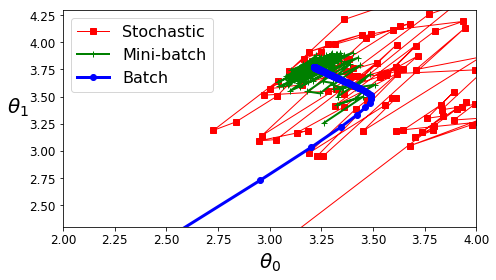

In [19]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.0, 4.0, 2.3, 4.3])
save_fig("gradient_descent_paths_plot")
plt.show()